
# 🎰 Gioco 5 — Scommessa dell'informazione (interattivo)
**Obiettivo didattico**: giocare prima, poi spiegare **entropia**, **cross-entropy / KL divergence** e **information gain** attraverso una scommessa su una sorgente di simboli.
  
Meccanica del gioco (fair odds):
- La sorgente emette un simbolo in un alfabeto di dimensione **m** con probabilità $p = (p_1,\dots,p_m)$.
- Prima dell'estrazione, il giocatore distribuisce il capitale tra i simboli: $q = (q_1,\dots,q_m)$, con $\sum q_i = 1$.
- Se esce il simbolo $i$, il capitale viene moltiplicato per **$q_i/p_i$** (quote “eque”: pagamento atteso neutro).

**Risultato chiave (da discutere dopo aver giocato)**: la strategia ottimale per la crescita logaritmica è **scommettere proporzionalmente a $p$**.  
La crescita log media è $\mathbb{E}[\log(W_{t+1}/W_t)] = H(p) - H(p,q) = -D_{KL}(p\Vert q) \le 0$.  
Quindi con quote eque, il massimo è 0 (nessuna crescita): ottieni 0 scegliendo **$q=p$**; peggio per scelte non ottimali.



## 0) Requisiti (esegui una volta se necessario)


In [ ]:

# Se mancano i pacchetti, scommentare ed eseguire:
# !pip install ipywidgets numpy pandas matplotlib
# !jupyter nbextension enable --py widgetsnbextension


## 1) Import e setup

In [1]:

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import math
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

SESSION_LOG = []  # per salvare risultati dei round manuali
CURRENT_STATE = {}  # stato corrente del gioco



## 2) Funzioni di utilità


In [2]:

def normalize(x):
    x = np.array(x, dtype=float)
    s = x.sum()
    if s <= 0:
        # default uniform if zero
        return np.ones_like(x) / len(x)
    return x / s

def sample_symbol(p):
    return np.random.choice(len(p), p=p)

def entropy_bits(p):
    p = np.array(p, dtype=float)
    p = p[p>0]
    return -np.sum(p * np.log2(p))

def cross_entropy_bits(p, q):
    p = np.array(p, dtype=float)
    q = np.array(q, dtype=float)
    mask = (p>0) & (q>0)
    return -np.sum(p[mask] * np.log2(q[mask]))

def kl_bits(p, q):
    # D_KL(p||q) in bit
    p = np.array(p, dtype=float)
    q = np.array(q, dtype=float)
    mask = (p>0) & (q>0)
    return np.sum(p[mask] * (np.log2(p[mask]) - np.log2(q[mask])))

def wealth_update(W, p, q, outcome):
    # W' = W * q_i / p_i
    return W * (q[outcome] / p[outcome])

def dirichlet_random(m):
    # random strategy over simplex (uniform Dirichlet)
    x = np.random.gamma(1.0, 1.0, size=m)
    return x / x.sum()

def set_state(m=4, p=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    if p is None:
        # default skewed distribution
        raw = np.linspace(1, m, m)
        raw = raw[::-1]  # decrescente
        p = normalize(raw)
    CURRENT_STATE.clear()
    CURRENT_STATE.update(dict(
        m=m,
        p=np.array(p, dtype=float),
        W=1.0,
        t=0
    ))
    return CURRENT_STATE

def reset_session_log():
    global SESSION_LOG
    SESSION_LOG = []

# inizializza
set_state()


{'m': 4, 'p': array([0.4, 0.3, 0.2, 0.1]), 'W': 1.0, 't': 0}


## 3) **Gioco manuale** (prima si gioca!)
1. Scegli la dimensione dell'alfabeto **m** e imposta le probabilità **p** (usa i cursori o i preset).
2. Premi **Nuova sessione**.
3. Scegli come distribuire la scommessa **q** (usa i cursori, poi *Normalizza q*).
4. Premi **Estrai & Valuta** (l'estrazione avviene dopo aver scelto q).  
5. Ripeti i round e registra i risultati.


In [ ]:

# --- Widgets setup ---
m_widget = widgets.BoundedIntText(value=4, min=2, max=12, step=1, description="m:")
seed_widget = widgets.IntText(value=0, description="Seed:")

# Probability sliders p
def create_p_sliders(m):
    sliders = []
    for i in range(m):
        s = widgets.FloatSlider(value=max(0.1, (m-i)), min=0.0, max=max(1.0, m), step=0.01,
                                description=f"p{i+1}*", readout_format=".2f", continuous_update=False)
        sliders.append(s)
    return sliders

p_sliders = create_p_sliders(m_widget.value)

normalize_p_btn = widgets.Button(description="↔️ Normalizza p", button_style="")
uniform_p_btn = widgets.Button(description="🎲 Uniforme p", button_style="")
skew_p_btn = widgets.Button(description="📈 Skew p", button_style="")
new_session_btn = widgets.Button(description="🚀 Nuova sessione", button_style="primary")

# Betting sliders q
def create_q_sliders(m):
    sliders = []
    for i in range(m):
        s = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.01,
                                description=f"q{i+1}", readout_format=".2f", continuous_update=False)
        sliders.append(s)
    return sliders

q_sliders = create_q_sliders(m_widget.value)
normalize_q_btn = widgets.Button(description="↔️ Normalizza q", button_style="")
uniform_q_btn = widgets.Button(description="🎯 Uniforme q", button_style="")

# Action buttons
play_btn = widgets.Button(description="🎰 Estrai & valuta", button_style="success")
record_btn = widgets.Button(description="💾 Registra round", button_style="warning")
reset_log_btn = widgets.Button(description="🧹 Azzera log", button_style="danger")
export_btn = widgets.Button(description="⬇️ Esporta CSV", button_style="")

# Outputs
status_out = widgets.Output()
p_out = widgets.Output()
q_out = widgets.Output()
log_out = widgets.Output()

def refresh_status():
    with status_out:
        clear_output()
        p = CURRENT_STATE["p"]
        H = entropy_bits(p)
        display(widgets.HTML(f"""<h4>Stato: m={CURRENT_STATE['m']} • Capitale W={CURRENT_STATE['W']:.4f} • Round t={CURRENT_STATE['t']}</h4>
        <div>Probabilità correnti p: {np.round(p,4)} (H(p) = {H:.3f} bit) — <i>non spiegarla prima del gioco</i></div>"""))

def rebuild_p_sliders(*args):
    global p_sliders, q_sliders
    m = m_widget.value
    p_sliders = create_p_sliders(m)
    q_sliders = create_q_sliders(m)
    with p_out:
        clear_output()
        display(widgets.VBox(p_sliders + [widgets.HBox([normalize_p_btn, uniform_p_btn, skew_p_btn])]))
    with q_out:
        clear_output()
        display(widgets.VBox(q_sliders + [widgets.HBox([normalize_q_btn, uniform_q_btn])]))
    refresh_status()

def get_p_from_sliders():
    vals = [s.value for s in p_sliders]
    return normalize(vals)

def get_q_from_sliders():
    vals = [s.value for s in q_sliders]
    return normalize(vals)

def on_normalize_p(_):
    vec = get_p_from_sliders()  # already normalized
    for s, v in zip(p_sliders, vec):
        s.value = float(v)

def on_uniform_p(_):
    vec = np.ones(m_widget.value) / m_widget.value
    for s, v in zip(p_sliders, vec):
        s.value = float(v)

def on_skew_p(_):
    m = m_widget.value
    raw = np.linspace(1, m, m)[::-1]
    vec = normalize(raw)
    for s, v in zip(p_sliders, vec):
        s.value = float(v)

def on_normalize_q(_):
    vec = get_q_from_sliders()
    for s, v in zip(q_sliders, vec):
        s.value = float(v)

def on_uniform_q(_):
    vec = np.ones(m_widget.value) / m_widget.value
    for s, v in zip(q_sliders, vec):
        s.value = float(v)

def on_new_session(_):
    m = m_widget.value
    p = get_p_from_sliders()
    set_state(m=m, p=p, seed=seed_widget.value or None)
    refresh_status()
    with log_out:
        clear_output()
        display(widgets.HTML("<i>Nuova sessione pronta. Gioca alcuni round e poi registra/esporta i risultati.</i>"))

def on_play(_):
    # ensure normalized q and p
    p = get_p_from_sliders()
    q = get_q_from_sliders()
    for s, v in zip(p_sliders, p):
        s.value = float(v)
    for s, v in zip(q_sliders, q):
        s.value = float(v)

    i = sample_symbol(p)  # outcome
    W_prev = CURRENT_STATE["W"]
    W_next = wealth_update(W_prev, p, q, i)
    CURRENT_STATE["W"] = float(W_next)
    CURRENT_STATE["t"] += 1

    # log (not yet in SESSION_LOG until user clicks record)
    with log_out:
        display(widgets.HTML(f"Round {CURRENT_STATE['t']}: esce simbolo <b>{i+1}</b>. "
                             f"Moltiplicatore = q/p = {q[i]:.4f}/{p[i]:.4f} = {(q[i]/p[i]):.4f}. "
                             f"Capitale: {W_prev:.4f} → {W_next:.4f}."))
    refresh_status()

def on_record(_):
    # Append a snapshot of current round in session log
    entry = dict(
        t=CURRENT_STATE["t"],
        m=CURRENT_STATE["m"],
        W=CURRENT_STATE["W"],
        p=list(map(float, get_p_from_sliders())),
        q=list(map(float, get_q_from_sliders()))
    )
    SESSION_LOG.append(entry)
    with log_out:
        display(widgets.HTML("<i>Round registrato.</i>"))

def on_export(_):
    if not SESSION_LOG:
        with log_out:
            display(widgets.HTML("Nessun round registrato."))
        return
    df = pd.DataFrame(SESSION_LOG)
    path = "/mnt/data/scommessa_sessione.csv"
    df.to_csv(path, index=False)
    with log_out:
        display(widgets.HTML(f"Esportato in: <code>{path}</code> — usa il link di download dell'assistente se disponibile."))

def on_reset_log(_):
    reset_session_log()
    with log_out:
        clear_output()
        display(widgets.HTML("Log azzerato."))

# Bind
m_widget.observe(lambda ch: rebuild_p_sliders(), names='value')
normalize_p_btn.on_click(on_normalize_p)
uniform_p_btn.on_click(on_uniform_p)
skew_p_btn.on_click(on_skew_p)

normalize_q_btn.on_click(on_normalize_q)
uniform_q_btn.on_click(on_uniform_q)

new_session_btn.on_click(on_new_session)
play_btn.on_click(on_play)
record_btn.on_click(on_record)
export_btn.on_click(on_export)
reset_log_btn.on_click(on_reset_log)

# Render UI
rebuild_p_sliders()
display(widgets.HBox([m_widget, seed_widget, new_session_btn]))
display(widgets.HTML("<h4>Probabilità p</h4>")); display(p_out)
display(widgets.HTML("<h4>Distribuzione scommessa q</h4>")); display(q_out)
display(widgets.HBox([play_btn, record_btn, export_btn, reset_log_btn]))
display(widgets.HTML("<hr>"))
display(widgets.HTML("<h4>Stato & Log</h4>")); display(status_out); display(log_out)


HTML(value='<h4>Probabilità p</h4>')

Output()

HTML(value='<h4>Distribuzione scommessa q</h4>')

Output()

HTML(value='<hr>')

HTML(value='<h4>Stato & Log</h4>')

Output()

Output()


## 4) **Dopo il gioco**: entropia, cross-entropy e information gain
Esegui questa sezione **solo dopo** aver giocato alcuni round.


In [4]:

p = get_p_from_sliders()
q = get_q_from_sliders()

H_p = entropy_bits(p)
H_pq = cross_entropy_bits(p, q)
D_pq = kl_bits(p, q)

print(f"H(p) = {H_p:.4f} bit")
print(f"H(p,q) = {H_pq:.4f} bit  (cross-entropy)")
print(f"D_KL(p||q) = {D_pq:.4f} bit")
print("\nInterpretazione: con quote eque, l'attesa di crescita log media = H(p) - H(p,q) = -D_KL(p||q) ≤ 0.")


H(p) = 1.8464 bit
H(p,q) = 1.8464 bit  (cross-entropy)
D_KL(p||q) = -0.0000 bit

Interpretazione: con quote eque, l'attesa di crescita log media = H(p) - H(p,q) = -D_KL(p||q) ≤ 0.



## 5) Duello tra agenti automatici
Confrontiamo due agenti su T round:
- **Agente Ottimo**: scommette \(q=p\) (proporzionale alle probabilità vere).
- **Agente Casuale**: ogni round campiona \(q\) da una **Dirichlet uniforme** (casuale sul semplice).

Mostriamo l’andamento del **log-capitale** e il differenziale di performance. Con quote eque ci aspettiamo:
- Ottimo: crescita log attesa **0**.
- Casuale: crescita log attesa **negativa**, pari a **\(-D_{KL}(p\Vert \text{Uniforme})\)** in media (se usa uniforme fisso; con Dirichlet la media è simile ma variabile per round).


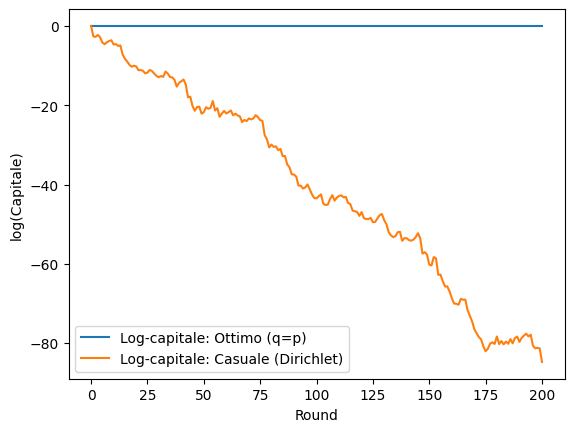

Esito finale su 200 round:
  Ottimo:   W=1.000000, logW=0.0000
  Casuale:  W=0.000000, logW=-84.7482

Differenza logW (Ottimo - Casuale): 84.7482


In [5]:

# Parametri simulazione
T = 200
p = get_p_from_sliders()
m = len(p)

W_opt = 1.0
W_rand = 1.0
logW_opt = [0.0]
logW_rand = [0.0]

for t in range(1, T+1):
    i = sample_symbol(p)
    q_opt = p  # proporzionale
    q_rand = dirichlet_random(m)  # casuale ogni round

    W_opt = wealth_update(W_opt, p, q_opt, i)
    W_rand = wealth_update(W_rand, p, q_rand, i)

    logW_opt.append(math.log(W_opt))
    logW_rand.append(math.log(W_rand))

# Plot (un grafico per regola del tool)
plt.figure()
plt.plot(range(T+1), logW_opt, label="Log-capitale: Ottimo (q=p)")
plt.plot(range(T+1), logW_rand, label="Log-capitale: Casuale (Dirichlet)")
plt.xlabel("Round")
plt.ylabel("log(Capitale)")
plt.legend()
plt.show()

print(f"Esito finale su {T} round:")
print(f"  Ottimo:   W={W_opt:.6f}, logW={math.log(W_opt):.4f}")
print(f"  Casuale:  W={W_rand:.6f}, logW={math.log(W_rand):.4f}")
print("\nDifferenza logW (Ottimo - Casuale): {:.4f}".format(math.log(W_opt) - math.log(W_rand)))



## 6) Tabella teorica (facoltativa)
Calcolo di $H(p)$, $\log_2 m$ e distanza dall'uniforme.


In [6]:

p = get_p_from_sliders()
m = len(p)
df = pd.DataFrame({
    "i": np.arange(1, m+1),
    "p_i": p,
    "log2(1/p_i)": np.log2(1.0/np.maximum(p, 1e-12)),  # informazione sorpresa per simbolo
})
display(df)
print(f"H(p) = {entropy_bits(p):.4f} bit,  log2(m) = {math.log2(m):.4f} bit,  margine = log2(m) - H(p) = {math.log2(m)-entropy_bits(p):.4f} bit")


,i,p_i,log2(1/p_i)
0,1,0.4,1.321928
1,2,0.3,1.736966
2,3,0.2,2.321928
3,4,0.1,3.321928


H(p) = 1.8464 bit,  log2(m) = 2.0000 bit,  margine = log2(m) - H(p) = 0.1536 bit
